In [ ]:
#export 
from fastai2.basics import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.vision.augment import *
from fastai2.vision import models

In [ ]:
#default_exp vision.learner

In [ ]:
from nbdev.showdoc import *

# Learner for the vision applications

> All the functions necessary to build `Learner` suitable for transfer learning in computer vision

## Cut a pretrained model

In [ ]:
# export
def _is_pool_type(l): return re.search(r'Pool[123]d$', l.__class__.__name__)

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
test_eq([bool(_is_pool_type(m_)) for m_ in m.children()], [True,False,False,True])

In [ ]:
# export
def has_pool_type(m):
    "Return `True` if `m` is a pooling layer or has one in its children"
    if _is_pool_type(m): return True
    for l in m.children():
        if has_pool_type(l): return True
    return False

In [ ]:
m = nn.Sequential(nn.AdaptiveAvgPool2d(5), nn.Linear(2,3), nn.Conv2d(2,3,1), nn.MaxPool3d(5))
assert has_pool_type(m)
test_eq([has_pool_type(m_) for m_ in m.children()], [True,False,False,True])

In [ ]:
# export
def _get_first_layer(m):
    "Access first layer of a model"
    c,p,n = m,None,None  # child, parent, name
    for n in next(m.named_parameters())[0].split('.')[:-1]:
        p,c=c,getattr(c,n)
    return c,p,n

In [ ]:
#export
def _load_pretrained_weights(new_layer, previous_layer):
    "Load pretrained weights based on number of input channels"
    n_in = getattr(new_layer, 'in_channels')
    if n_in==1:
        # we take the sum
        new_layer.weight.data = previous_layer.weight.data.sum(dim=1, keepdim=True)
    elif n_in==2:
        # we take first 2 channels + 50%
        new_layer.weight.data = previous_layer.weight.data[:,:2] * 1.5
    else:
        # keep 3 channels weights and set others to null
        new_layer.weight.data[:,:3] = previous_layer.weight.data
        new_layer.weight.data[:,3:].zero_()

In [ ]:
#export
def _update_first_layer(model, n_in, pretrained):
    "Change first layer based on number of input channels"
    if n_in == 3: return
    first_layer, parent, name = _get_first_layer(model)
    assert isinstance(first_layer, nn.Conv2d), f'Change of input channels only supported with Conv2d, found {first_layer.__class__.__name__}'
    assert getattr(first_layer, 'in_channels') == 3, f'Unexpected number of input channels, found {getattr(first_layer, "in_channels")} while expecting 3'
    params = {attr:getattr(first_layer, attr) for attr in 'out_channels kernel_size stride padding dilation groups padding_mode'.split()}
    params['bias'] = getattr(first_layer, 'bias') is not None
    params['in_channels'] = n_in
    new_layer = nn.Conv2d(**params)
    if pretrained:
        _load_pretrained_weights(new_layer, first_layer)
    setattr(parent, name, new_layer)

In [ ]:
#export
def create_body(arch, n_in=3, pretrained=True, cut=None):
    "Cut off the body of a typically pretrained `arch` as determined by `cut`"
    model = arch(pretrained=pretrained)
    _update_first_layer(model, n_in, pretrained)
    #cut = ifnone(cut, cnn_config(arch)['cut'])
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if   isinstance(cut, int):      return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else:                           raise NamedError("cut must be either integer or a function")

`cut` can either be an integer, in which case we cut the model at the coresponding layer, or a function, in which case, this funciton returns `cut(model)`. It defaults to `cnn_config(arch)['cut']` if `arch` is in `cnn_config`, otherwise to the first layer that contains some pooling.

In [ ]:
tst = lambda pretrained : nn.Sequential(nn.Conv2d(3,5,3), nn.BatchNorm2d(5), nn.AvgPool2d(1), nn.Linear(3,4))
m = create_body(tst)
test_eq(len(m), 2)

m = create_body(tst, cut=3)
test_eq(len(m), 3)

m = create_body(tst, cut=noop)
test_eq(len(m), 4)

for n in range(1,5):    
    m = create_body(tst, n_in=n)
    test_eq(_get_first_layer(m)[0].in_channels, n)

## Head and model

In [ ]:
#export
def create_head(nf, n_out, lin_ftrs=None, ps=0.5, concat_pool=True, bn_final=False, lin_first=False, y_range=None):
    "Model head that takes `nf` features, runs through `lin_ftrs`, and out `n_out` classes."
    lin_ftrs = [nf, 512, n_out] if lin_ftrs is None else [nf] + lin_ftrs + [n_out]
    ps = L(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    if lin_first: layers.append(nn.Dropout(ps.pop(0)))
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += LinBnDrop(ni, no, bn=True, p=p, act=actn, lin_first=lin_first)
    if lin_first: layers.append(nn.Linear(lin_ftrs[-2], n_out))
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    if y_range is not None: layers.append(SigmoidRange(*y_range))
    return nn.Sequential(*layers)

In [ ]:
tst = create_head(5, 10)
tst

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): full: False
  (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=5, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=10, bias=False)
)

In [ ]:
#hide
mods = list(tst.children())
test_eq(len(mods), 9)
assert isinstance(mods[2], nn.BatchNorm1d)
assert isinstance(mods[-1], nn.Linear)

tst = create_head(5, 10, lin_first=True)
mods = list(tst.children())
test_eq(len(mods), 8)
assert isinstance(mods[2], nn.Dropout)

In [ ]:
#export
from fastai2.callback.hook import num_features_model

In [ ]:
#export
def create_cnn_model(arch, n_out, cut, pretrained, n_in=3, lin_ftrs=None, ps=0.5, custom_head=None,
                     bn_final=False, concat_pool=True, y_range=None, init=nn.init.kaiming_normal_):
    "Create custom convnet architecture using `base_arch`"
    body = create_body(arch, n_in, pretrained, cut)
    if custom_head is None:
        nf = num_features_model(nn.Sequential(*body.children())) * (2 if concat_pool else 1)
        head = create_head(nf, n_out, lin_ftrs, ps=ps, concat_pool=concat_pool, bn_final=bn_final, y_range=y_range)
    else: head = custom_head
    model = nn.Sequential(body, head)
    if init is not None: apply_init(model[1], init)
    return model

In [ ]:
tst = create_cnn_model(models.resnet18, 10, None, True)
tst = create_cnn_model(models.resnet18, 10, None, True, n_in=1)

In [ ]:
#export
@delegates(create_cnn_model)
def cnn_config(**kwargs):
    "Convenience function to easily create a config for `create_cnn_model`"
    return kwargs

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

dls = pets.dataloaders(untar_data(URLs.PETS)/"images", item_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        batch_tfms=[*aug_transforms(size=224)])

In [ ]:
#TODO: refactor, i.e. something like this?
# class ModelSplitter():
#     def __init__(self, idx): self.idx = idx
#     def split(self, m): return L(m[:self.idx], m[self.idx:]).map(params)
#     def __call__(self,): return {'cut':self.idx, 'split':self.split}

In [ ]:
#export
def default_split(m:nn.Module): return L(m[0], m[1:]).map(params)

In [ ]:
#export
def _xresnet_split(m): return L(m[0][:3], m[0][3:], m[1:]).map(params)
def  _resnet_split(m): return L(m[0][:6], m[0][6:], m[1:]).map(params)
def _squeezenet_split(m:nn.Module): return L(m[0][0][:5], m[0][0][5:], m[1:]).map(params)
def _densenet_split(m:nn.Module): return L(m[0][0][:7],m[0][0][7:], m[1:]).map(params)
def _vgg_split(m:nn.Module): return L(m[0][0][:22], m[0][0][22:], m[1:]).map(params)
def _alexnet_split(m:nn.Module): return L(m[0][0][:6], m[0][0][6:], m[1:]).map(params)

_default_meta    = {'cut':None, 'split':default_split}
_xresnet_meta    = {'cut':-4, 'split':_xresnet_split, 'stats':imagenet_stats}
_resnet_meta     = {'cut':-2, 'split':_resnet_split, 'stats':imagenet_stats}
_squeezenet_meta = {'cut':-1, 'split': _squeezenet_split, 'stats':imagenet_stats}
_densenet_meta   = {'cut':-1, 'split':_densenet_split, 'stats':imagenet_stats}
_vgg_meta        = {'cut':-2, 'split':_vgg_split, 'stats':imagenet_stats}
_alexnet_meta    = {'cut':-2, 'split':_alexnet_split, 'stats':imagenet_stats}

In [ ]:
#export
model_meta = {
    models.xresnet.xresnet18 :{**_xresnet_meta}, models.xresnet.xresnet34: {**_xresnet_meta},
    models.xresnet.xresnet50 :{**_xresnet_meta}, models.xresnet.xresnet101:{**_xresnet_meta},
    models.xresnet.xresnet152:{**_xresnet_meta},

    models.resnet18 :{**_resnet_meta}, models.resnet34: {**_resnet_meta},
    models.resnet50 :{**_resnet_meta}, models.resnet101:{**_resnet_meta},
    models.resnet152:{**_resnet_meta},

    models.squeezenet1_0:{**_squeezenet_meta},
    models.squeezenet1_1:{**_squeezenet_meta},

    models.densenet121:{**_densenet_meta}, models.densenet169:{**_densenet_meta},
    models.densenet201:{**_densenet_meta}, models.densenet161:{**_densenet_meta},
    models.vgg11_bn:{**_vgg_meta}, models.vgg13_bn:{**_vgg_meta}, models.vgg16_bn:{**_vgg_meta}, models.vgg19_bn:{**_vgg_meta},
    models.alexnet:{**_alexnet_meta}}

## `Learner` convenience functions

In [ ]:
#export
def _add_norm(dls, meta, pretrained):
    if not pretrained: return
    after_batch = dls.after_batch
    if first(o for o in after_batch.fs if isinstance(o,Normalize)): return
    stats = meta.get('stats')
    if stats is None: return
    after_batch.add(Normalize.from_stats(*stats))

In [ ]:
#export
@delegates(Learner.__init__)
def cnn_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, 
                y_range=None, config=None, n_in=3, n_out=None, normalize=True, **kwargs):
    "Build a convnet style learner"
    if config is None: config = {}
    meta = model_meta.get(arch, _default_meta)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    if normalize: _add_norm(dls, meta, pretrained)
    model = create_cnn_model(arch, n_out, ifnone(cut, meta['cut']), pretrained, n_in=n_in, y_range=y_range, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

The model is built from `arch` using the number of final activation inferred from `dls` by `get_c`. It might be `pretrained` and the architecture is cut and split using the default metadata of the model architecture (this can be customized by passing a `cut` or a `splitter`). To customize the model creation, use `cnn_config` and pass the result to the `config` argument.

In [ ]:
learn = cnn_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(), config=cnn_config(ps=0.25))

In [ ]:
test_eq(to_cpu(dls.after_batch[1].mean[0].squeeze()), tensor(imagenet_stats[0]))

In [ ]:
#export
@delegates(models.unet.DynamicUnet.__init__)
def unet_config(**kwargs):
    "Convenience function to easily create a config for `DynamicUnet`"
    return kwargs

In [ ]:
#export
@delegates(Learner.__init__)
def unet_learner(dls, arch, loss_func=None, pretrained=True, cut=None, splitter=None, config=None, n_in=3, n_out=None, **kwargs):
    "Build a unet learner from `dls` and `arch`"
    if config is None: config = unet_config()
    meta = model_meta.get(arch, _default_meta)
    body = create_body(arch, n_in, pretrained, ifnone(cut, meta['cut']))
    size = dls.one_batch()[0].shape[-2:]
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be infered from data, set `dls.c` or pass `n_out`"
    model = models.unet.DynamicUnet(body, n_out, size, **config)
    learn = Learner(dls, model, loss_func=loss_func, splitter=ifnone(splitter, meta['split']), **kwargs)
    if pretrained: learn.freeze()
    return learn

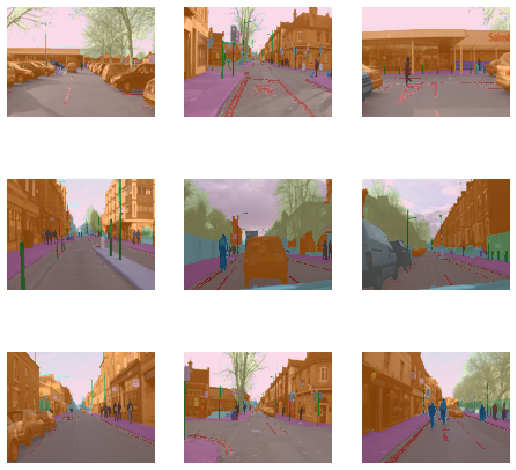

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: untar_data(URLs.CAMVID_TINY)/'labels'/f'{o.stem}_P{o.suffix}')

dls = camvid.dataloaders(untar_data(URLs.CAMVID_TINY)/"images", batch_tfms=aug_transforms())
dls.show_batch(max_n=9, vmin=1, vmax=30)

In [ ]:
#TODO: Find a way to pass the classes properly
dls.vocab = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)

In [ ]:
learn = unet_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(axis=1))
learn = unet_learner(dls, models.resnet34, pretrained=True, n_in=4)

## Show functions

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y, samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    ctxs = show_results[object](x, y, samples, outs, ctxs=ctxs, max_n=max_n, **kwargs)
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:TensorCategory, samples, outs, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i in range(2):
        ctxs = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs,range(max_n))]
    ctxs = [r.show(ctx=c, color='green' if b==r else 'red', **kwargs)
            for b,r,c,_ in zip(samples.itemgot(1),outs.itemgot(0),ctxs,range(max_n))]
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:(TensorMask, TensorPoint, TensorBBox), samples, outs, ctxs=None, max_n=6, rows=None, cols=1, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(len(samples), max_n), rows=rows, cols=cols, add_vert=1, figsize=figsize, double=True, 
                                     title='Target/Prediction')
    for i in range(2):
        ctxs[::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[::2],range(2*max_n))]
    for o in [samples,outs]:
        ctxs[1::2] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(o.itemgot(0),ctxs[1::2],range(2*max_n))]
    return ctxs

In [ ]:
#export
@typedispatch
def show_results(x:TensorImage, y:TensorImage, samples, outs, ctxs=None, max_n=10, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(samples), max_n), cols=3, figsize=figsize, title='Input/Target/Prediction')
    for i in range(2):
        ctxs[i::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(samples.itemgot(i),ctxs[i::3],range(max_n))]
    ctxs[2::3] = [b.show(ctx=c, **kwargs) for b,c,_ in zip(outs.itemgot(0),ctxs[2::3],range(max_n))]
    return ctxs

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize, title='Prediction/Actual/Loss/Probability')
    for ax,s,o,r,l in zip(axs, samples, outs, raws, losses):
        s[0].show(ctx=ax, **kwargs)
        ax.set_title(f'{o[0]}/{s[1]} / {l.item():.2f} / {r.max().item():.2f}')

In [ ]:
#export
@typedispatch
def plot_top_losses(x: TensorImage, y:TensorMultiCategory, samples, outs, raws, losses, rows=None, cols=None, figsize=None, **kwargs):
    axs = get_grid(len(samples), rows=rows, cols=cols, add_vert=1, figsize=figsize)
    for i,(ax,s) in enumerate(zip(axs, samples)): s[0].show(ctx=ax, title=f'Image {i}', **kwargs)
    rows = get_empty_df(len(samples))
    outs = L(s[1:] + o + (TitledStr(r), TitledFloat(l.item())) for s,o,r,l in zip(samples, outs, raws, losses))
    for i,l in enumerate(["target", "predicted", "probabilities", "loss"]):
        rows = [b.show(ctx=r, label=l, **kwargs) for b,r in zip(outs.itemgot(i),rows)]
    display_df(pd.DataFrame(rows))

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 13a_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 19_callback.mixup.ipynb.
Converted 20_interpret.ipynb.
Converted 20a_distributed.ipynb.
Converted 21_vision.learner.ipynb.
Converted 22_tutorial.imagenette.ipynb.
Converted 23_tutoria